In [152]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



In [153]:
df = pd.read_csv("Medical Insurance Train Data.csv")
print(df.isna().sum())
df.head(5)

age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64


,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


In [154]:
# transformer for sex, religion, and smoker
trf = ColumnTransformer([
    ('t1', (OneHotEncoder(sparse_output=False)), ['sex']),
    ('t2', (OneHotEncoder(sparse_output=False)), ['region']),
    ('t3', (OneHotEncoder(sparse_output=False)), ['smoker'])
    
], remainder='passthrough', verbose_feature_names_out=False)

# verbose_feature_names_out=False --- remove this and you will see the feature names would change 


df = pd.DataFrame(trf.fit_transform(df), columns=trf.get_feature_names_out())
print(df.head())

print('*******************************************************************************************************************')

# using scaler on all features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()


   sex_female  sex_male  region_northeast  region_northwest  region_southeast  \
0         0.0       1.0               1.0               0.0               0.0   
1         1.0       0.0               0.0               0.0               1.0   
2         0.0       1.0               0.0               0.0               1.0   
3         0.0       1.0               1.0               0.0               0.0   
4         0.0       1.0               0.0               0.0               1.0   

   region_southwest  smoker_no  smoker_yes        age        bmi  children  \
0               0.0        1.0         0.0  21.000000  25.745000       2.0   
1               0.0        0.0         1.0  36.976978  25.744165       3.0   
2               0.0        1.0         0.0  18.000000  30.030000       1.0   
3               0.0        1.0         0.0  37.000000  30.676891       3.0   
4               0.0        1.0         0.0  58.000000  32.010000       1.0   

        charges  
0   3279.868550  
1  21454

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes,age,bmi,children,charges
0,-0.888290,0.888290,1.811259,-0.578835,-0.625570,-0.552952,0.427095,-0.427095,-1.472262,-0.897822,-0.294091,-0.884618
1,1.125759,-1.125759,-0.552102,-0.578835,1.598542,-0.552952,-2.341398,2.341398,-0.157215,-0.897976,0.289908,0.806881
2,-0.888290,0.888290,-0.552102,-0.578835,1.598542,-0.552952,0.427095,-0.427095,-1.719189,-0.110219,-0.878090,-1.029761
3,-0.888290,0.888290,1.811259,-0.578835,-0.625570,-0.552952,0.427095,-0.427095,-0.155320,0.008683,0.289908,-0.556868
4,-0.888290,0.888290,-0.552102,-0.578835,1.598542,-0.552952,0.427095,-0.427095,1.573167,0.253714,-0.878090,-0.078009


##### **Making universal train_test_split()**

In [155]:
X = df_scaled.drop(columns='charges')
y = df_scaled['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(3630, 11)
(3630,)
(2904, 11)
(2904,)
(726, 11)
(726,)


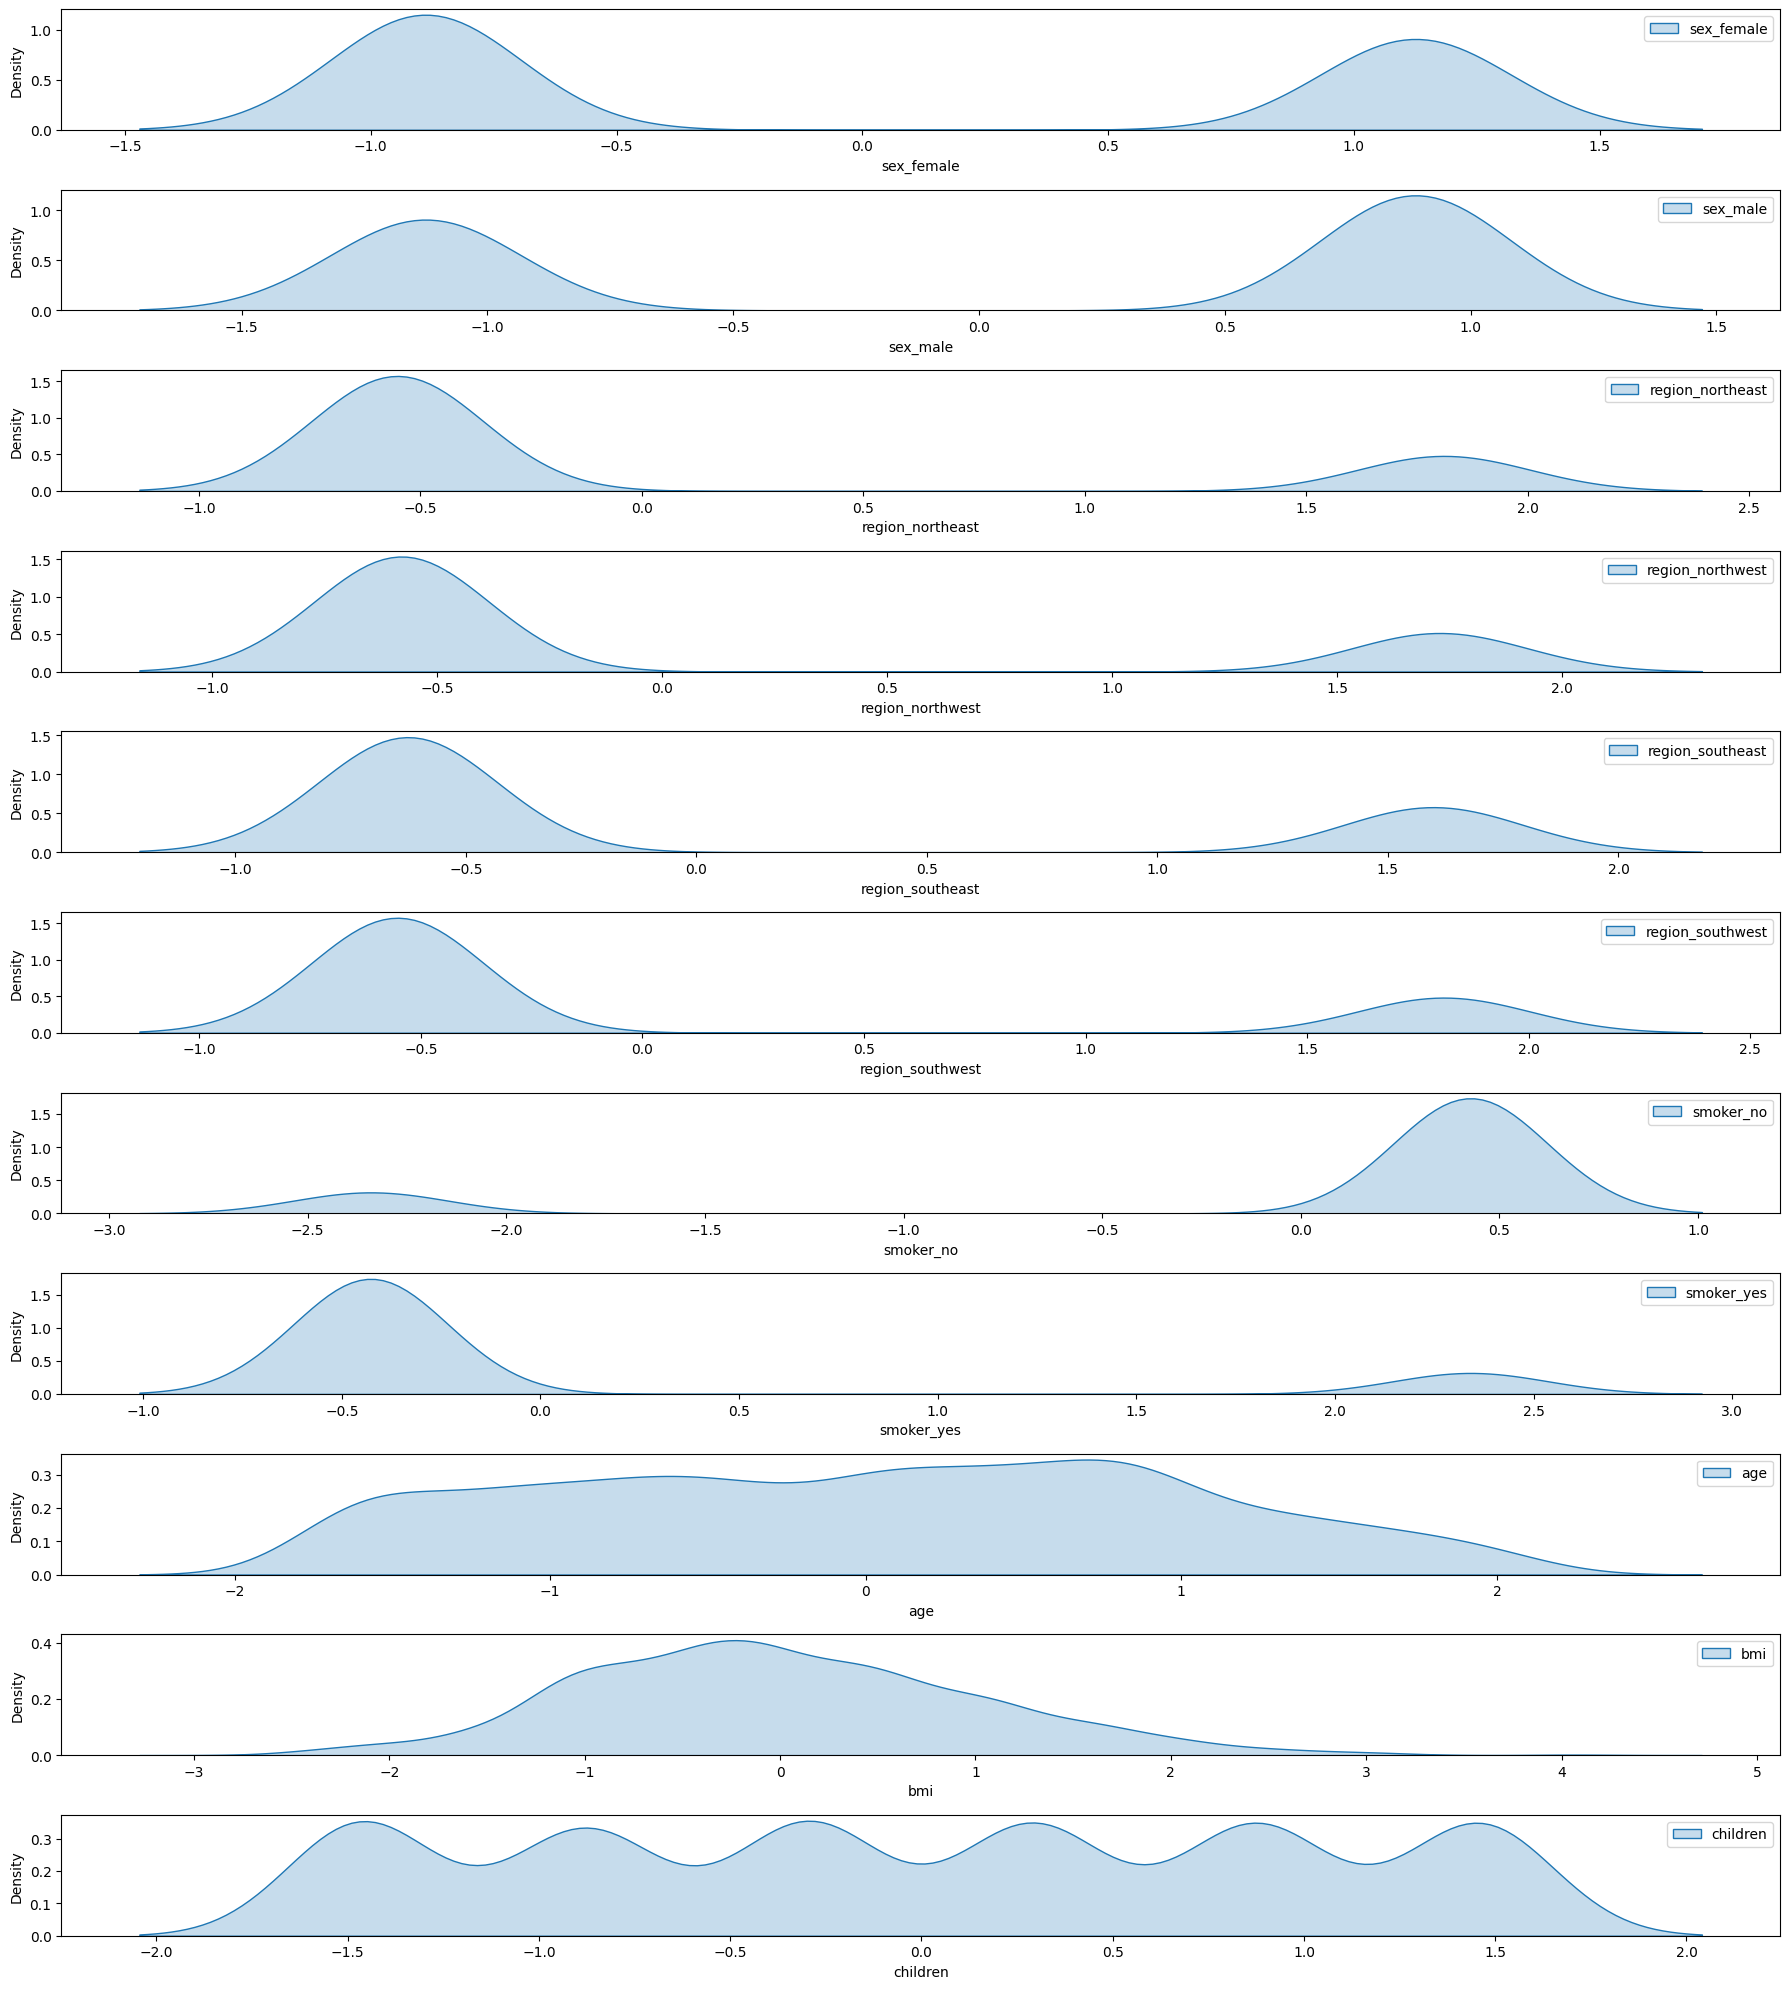

In [156]:
# checking if the data is normally distributed or not 

plt.figure(figsize=(18, 20))

for i, cols in enumerate(X.columns):
    plt.subplot(len(X.columns), 1, i+1)
    sns.kdeplot(X[cols], fill=True, label=cols)
    plt.legend()
    plt.tight_layout()


plt.show()

# since the all the datas are not normally distributed hence we cant use z-score method, Now we have to use other methods like IQR method / percentile method 

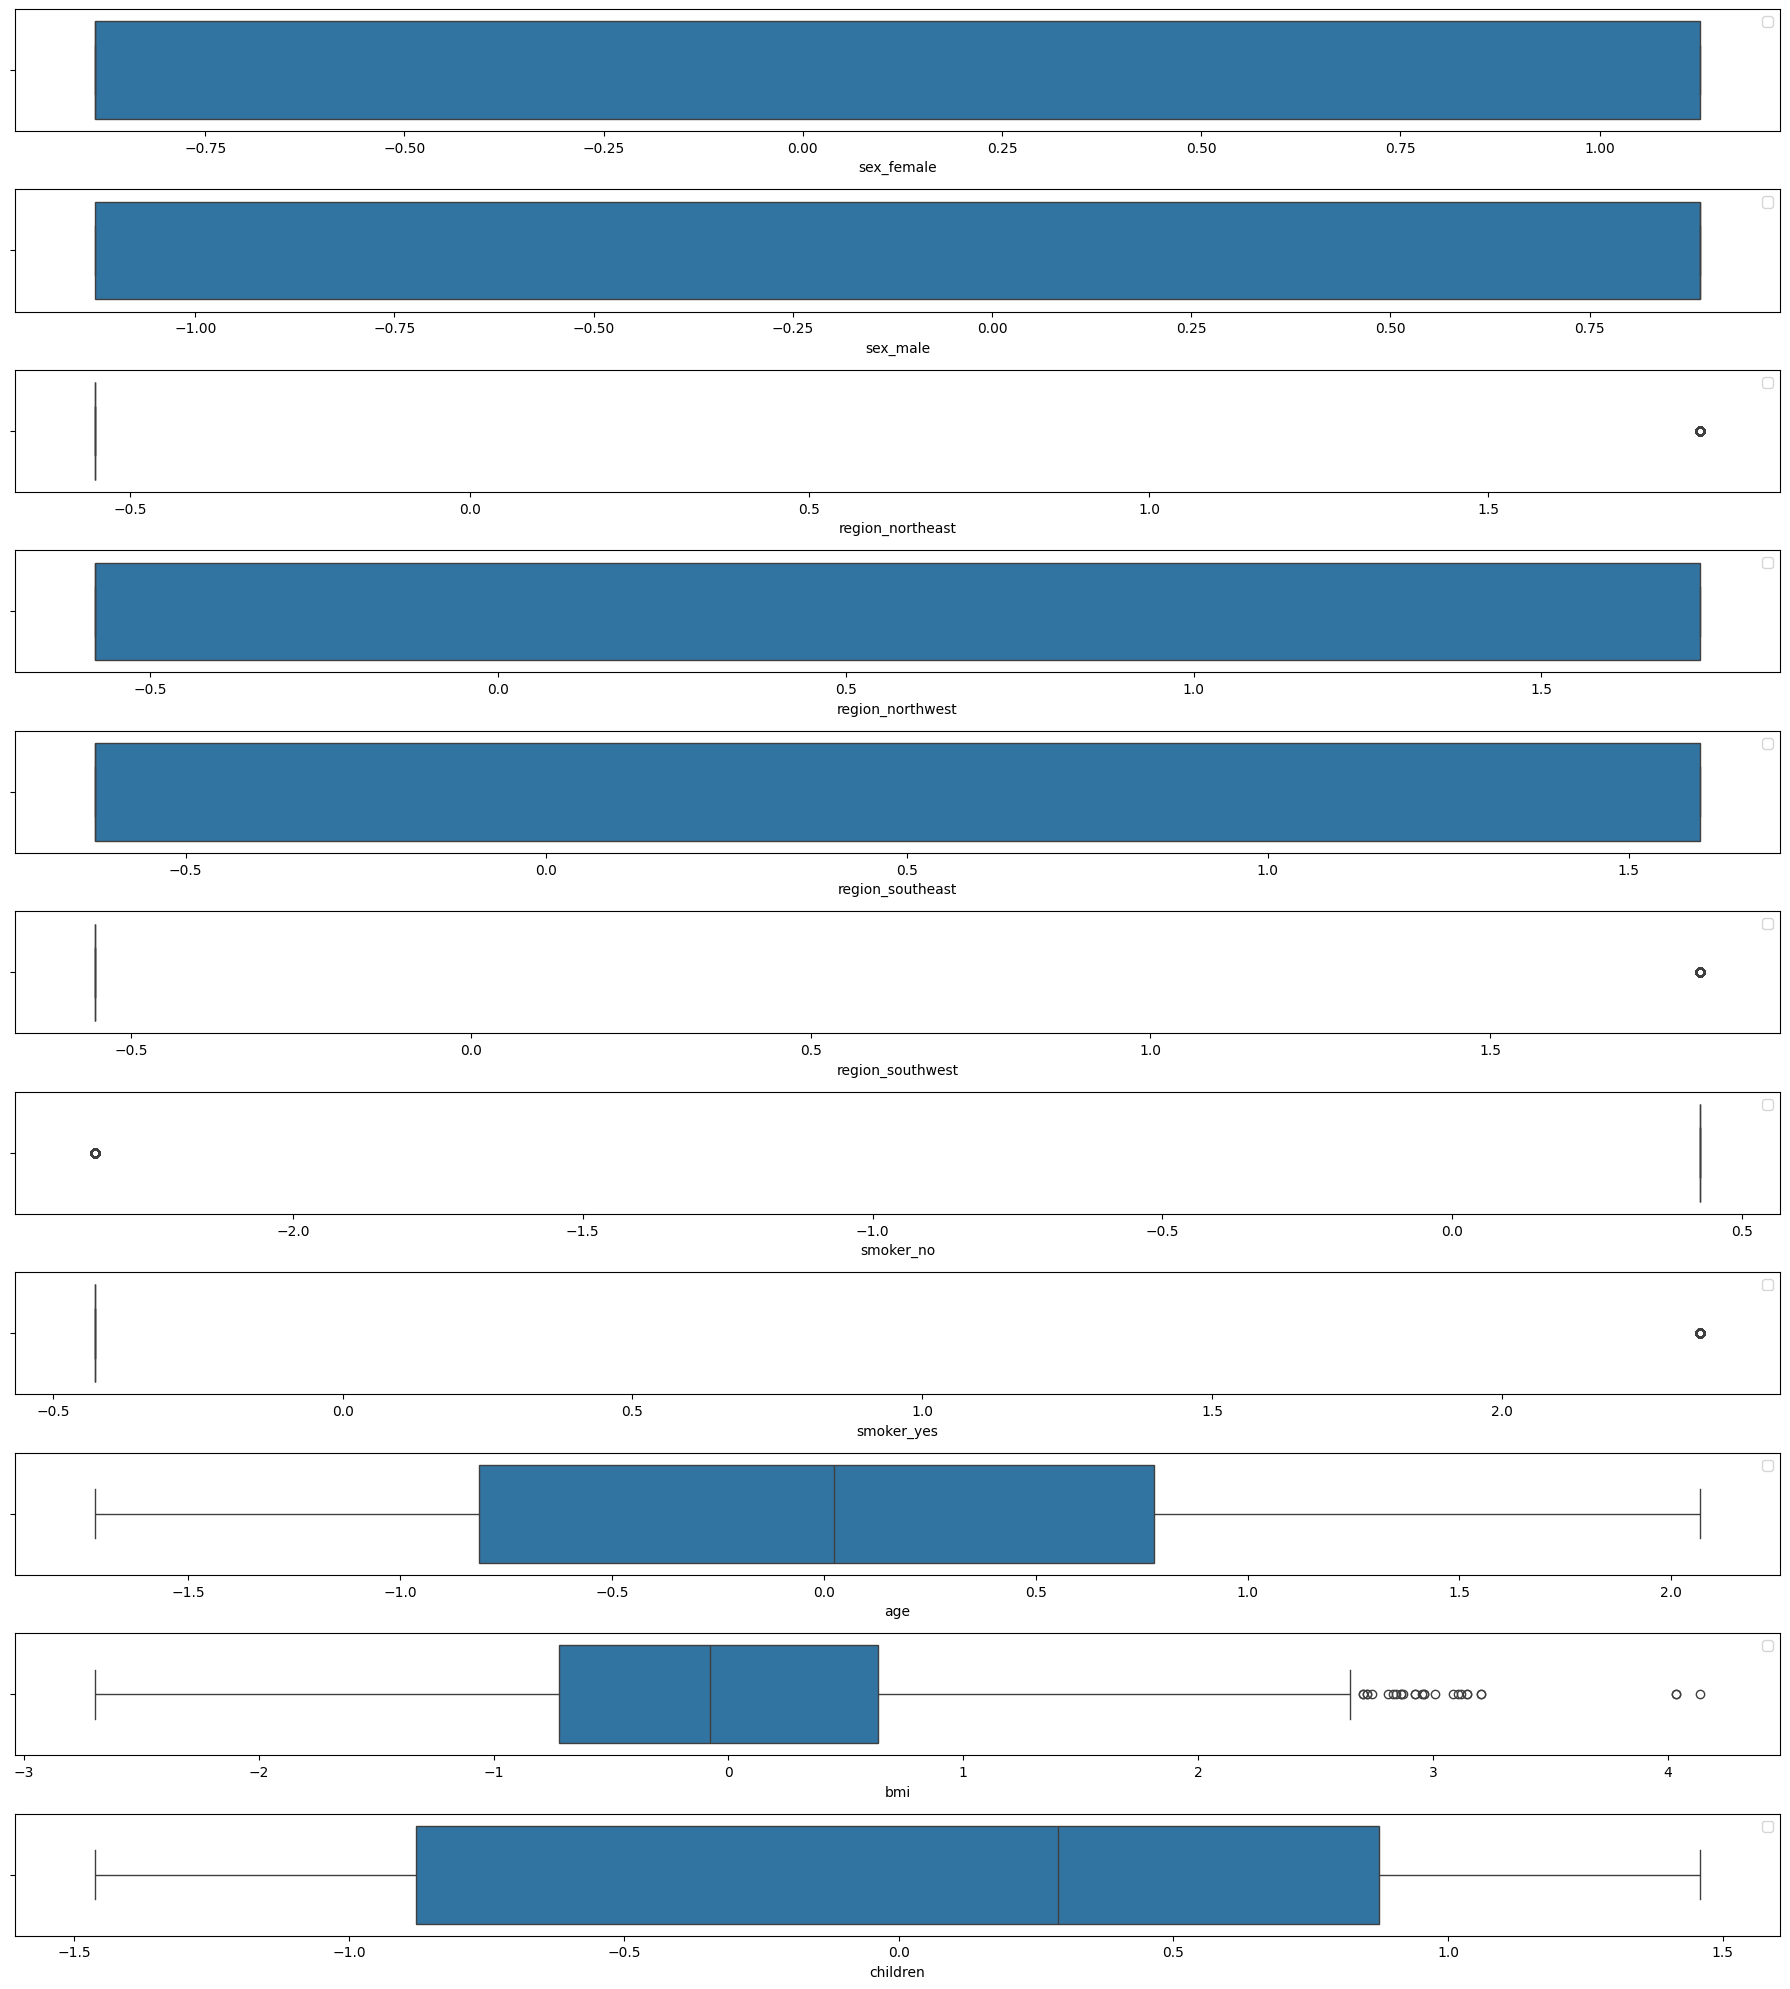

In [157]:
# checking for outliers
plt.figure(figsize=(18,20))
for i, cols in enumerate(X.columns):
    plt.subplot(len(X.columns), 1, i+1)
    sns.boxplot(x=X[cols])
    plt.tight_layout()
    plt.legend()
plt.show()

0.3534850185359985


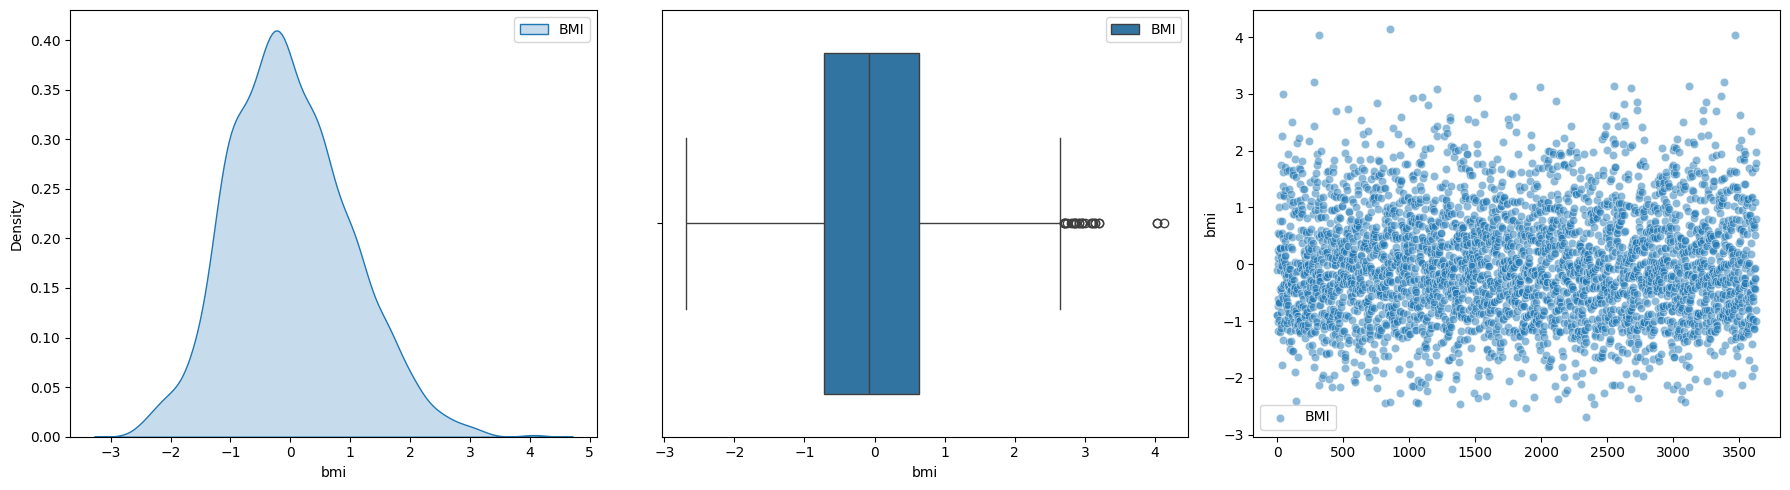

In [158]:
# since bmi is the only feature that holds outlier we have to apply IQR method on it
print(X['bmi'].skew())      # this will print the skewness in the bmi feature, in other words it represents the number of outliers ie 35%

plt.figure(figsize=(18,5))
plt.subplot(131)
sns.kdeplot(X['bmi'], fill='true', label='BMI')
plt.legend()

plt.subplot(132)
sns.boxplot(x=X['bmi'], label='BMI')
plt.legend()

plt.subplot(133)
sns.scatterplot(X['bmi'], label='BMI', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

### **IQR method**

In [ ]:
new_df = X.copy()

print(new_df['bmi'].describe())

percentile_25 = X['bmi'].quantile(0.25)
percentile_75 = X['bmi'].quantile(0.75)

iqr = percentile_75 - percentile_25
# print(iqr)        # will print iqr of all columns

upper_limit = percentile_75 + 1.5*iqr
lower_limit = percentile_25 - 1.5*iqr


# ********************************************************************************************************************************************************

# apply the code below if you want to handle outlier by removing them, but remember it will also lead to the loss of valuable data
# new_df = new_df[(new_df['bmi'] > lower_limit) & (new_df['bmi'] < upper_limit)]


# IQR using capping
new_df['bmi'] = np.where(
    new_df['bmi'] > upper_limit,
    upper_limit,
    np.where(
        new_df['bmi'] < lower_limit,
        lower_limit,
        new_df['bmi']
    )
)

print('UPPER LIMIT :', upper_limit)
print('LOWER LIMIT :', lower_limit)

print(new_df.shape)
new_df.head()






count    3.630000e+03
mean    -1.873004e-14
std      1.000138e+00
min     -2.696351e+00
25%     -7.232946e-01
50%     -7.897214e-02
75%      6.378662e-01
max      4.135669e+00
Name: bmi, dtype: float64
UPPER LIMIT : 2.6796073733526367
LOWER LIMIT : -2.765035858688476
(3630, 11)


,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes,age,bmi,children
0,-0.888290,0.888290,1.811259,-0.578835,-0.625570,-0.552952,0.427095,-0.427095,-1.472262,-0.897822,-0.294091
1,1.125759,-1.125759,-0.552102,-0.578835,1.598542,-0.552952,-2.341398,2.341398,-0.157215,-0.897976,0.289908
2,-0.888290,0.888290,-0.552102,-0.578835,1.598542,-0.552952,0.427095,-0.427095,-1.719189,-0.110219,-0.878090
3,-0.888290,0.888290,1.811259,-0.578835,-0.625570,-0.552952,0.427095,-0.427095,-0.155320,0.008683,0.289908
4,-0.888290,0.888290,-0.552102,-0.578835,1.598542,-0.552952,0.427095,-0.427095,1.573167,0.253714,-0.878090


### **Linear Regression**

In [ ]:
# here we are applying linear reg based on universal train_test_split

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.coef_)             # there will be 11 coefs for 11 features
print(lr.intercept_)
print()

print('ACCURACY \t : ', np.round(r2_score(y_test, y_pred), 2)*100, '%')
print('MAE \t\t : ', mean_absolute_error(y_test, y_pred))
print('MSE \t\t : ', mean_squared_error(y_test, y_pred))
print('RMSE \t\t : ', root_mean_squared_error(y_test, y_pred))
print('CROSS VAL SCORE  : ', np.mean(cross_val_score(lr, X_train, y_train, cv=10)))


# practically GridSearchCV doesnt work on linear reg
# gcv = GridSearchCV()


[-0.02219943  0.02219943  0.06474977 -0.02557354 -0.01113246 -0.02669382
 -0.3802811   0.3802811   0.26629794  0.14798948  0.08087402]
-0.006248361037141712

ACCURACY 	 :  72.0 %
MAE 		 :  0.3530867836717338
MSE 		 :  0.27855460348838745
RMSE 		 :  0.5277827237494492
CROSS VAL SCORE  :  0.7140832763553291


In [ ]:
X = new_df.copy()
y = df_scaled['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# here we are applying linear reg based on the new formed train_test_split, which is not prone to outliers

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.coef_)             # there will be 11 coefs for 11 features
print(lr.intercept_)
print()

print('ACCURACY \t : ', np.round(r2_score(y_test, y_pred), 2)*100, '%')
print('MAE \t\t : ', mean_absolute_error(y_test, y_pred))
print('MSE \t\t : ', mean_squared_error(y_test, y_pred))
print('RMSE \t\t : ', root_mean_squared_error(y_test, y_pred))
print('CROSS VAL SCORE  : ', np.mean(cross_val_score(lr, X_train, y_train, cv=10)))


[-0.02224303  0.02224303  0.06458251 -0.02576177 -0.010715   -0.02677722
 -0.38040825  0.38040825  0.26598751  0.14885043  0.08054759]
-0.005775981886881099

ACCURACY 	 :  72.0 %
MAE 		 :  0.3531536898810522
MSE 		 :  0.2782929376566464
RMSE 		 :  0.5275347738838136
CROSS VAL SCORE  :  0.7139099886653993


### **Gradient Descent**